In [1]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

# region for West Africa time series analysis
box_str <- paste0(c(-16,20,10,17), collapse = "_")


── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/RtmpaQgQ6K/remotes20f9e13e0abf1/clairbarnes-rwwa-b8b654b/DESCRIPTION’
─  preparing ‘rwwa’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘rwwa_0.1.1.tar.gz’
   


Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot


Loading required package: plyr


Attaching package: ‘plyr’


The following object is masked from ‘package:distillery’:

    is.formula




# Observations

## Model results for all available time series

In [7]:
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# fit all the models
models <- sapply(list.files("ts", pattern = "sahel-heat_tx5x-april_-16", full.names = T), function(fnm) {
    
    df <- merge(gmst, load_ts(fnm, col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
    
}, simplify = F)

In [8]:
# bootstrap all the parameter estimates

for( mnm in names(models)) {
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", mnm))
    if(!file.exists(res_fnm)) {
        mdl <- models[[mnm]]
        res <- boot_ci(mdl, cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 1000)
        write.csv(res, res_fnm)
    }
}

In [106]:
df <- merge(gmst, load_ts("ts/sahel-heat_tx5x-april_mali-bf_era5.dat", col.names = c("year", "tas")))
df <- df[df$year >= 1979,]
mdl <- fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)
res <- boot_ci(mdl, cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 1000)

### Tables of parameter estimates

In [83]:
# load all the bootstrapped results
res_apr <- abind::abind(sapply(list.files("res", pattern = "sahel-heat_tx.x-april_m", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)
res_mam <- abind::abind(sapply(list.files("res", pattern = "sahel-heat_tx.x-mam_m", full.names = T), read.csv, row.names = "X", simplify = F), along = 0)

res_apr[!is.finite(res_apr)] <- NA
res_mam[!is.finite(res_mam)] <- NA

res_apr <- data.frame("ds" = sapply(rownames(res_apr), function(rnm) gsub(".csv", "", strsplit(rnm, "_")[[1]][5])),
           "tx" = sapply(rownames(res_apr), function(rnm) substr(strsplit(rnm, "_")[[1]][3],1,4)),
           "rp_apr" = round(res_apr[,"return_period","est"],0))
                                    
res_mam <- data.frame("ds" = sapply(rownames(res_mam), function(rnm) gsub(".csv", "", strsplit(rnm, "_")[[1]][5])),
           "tx" = sapply(rownames(res_mam), function(rnm) substr(strsplit(rnm, "_")[[1]][3],1,4)),
                         "rp_mam" = round(res_mam[,"return_period","est"],0))

In [84]:
t(merge(res_apr, res_mam))

ds,cpc,cpc,cpc,era5,era5,era5,mswx,mswx,mswx
tx,tx1x,tx3x,tx5x,tx1x,tx3x,tx5x,tx1x,tx3x,tx5x
rp_apr,173,252,231,20,45,37,121,136,264
rp_mam,82,205,206,18,54,49,115,139,329


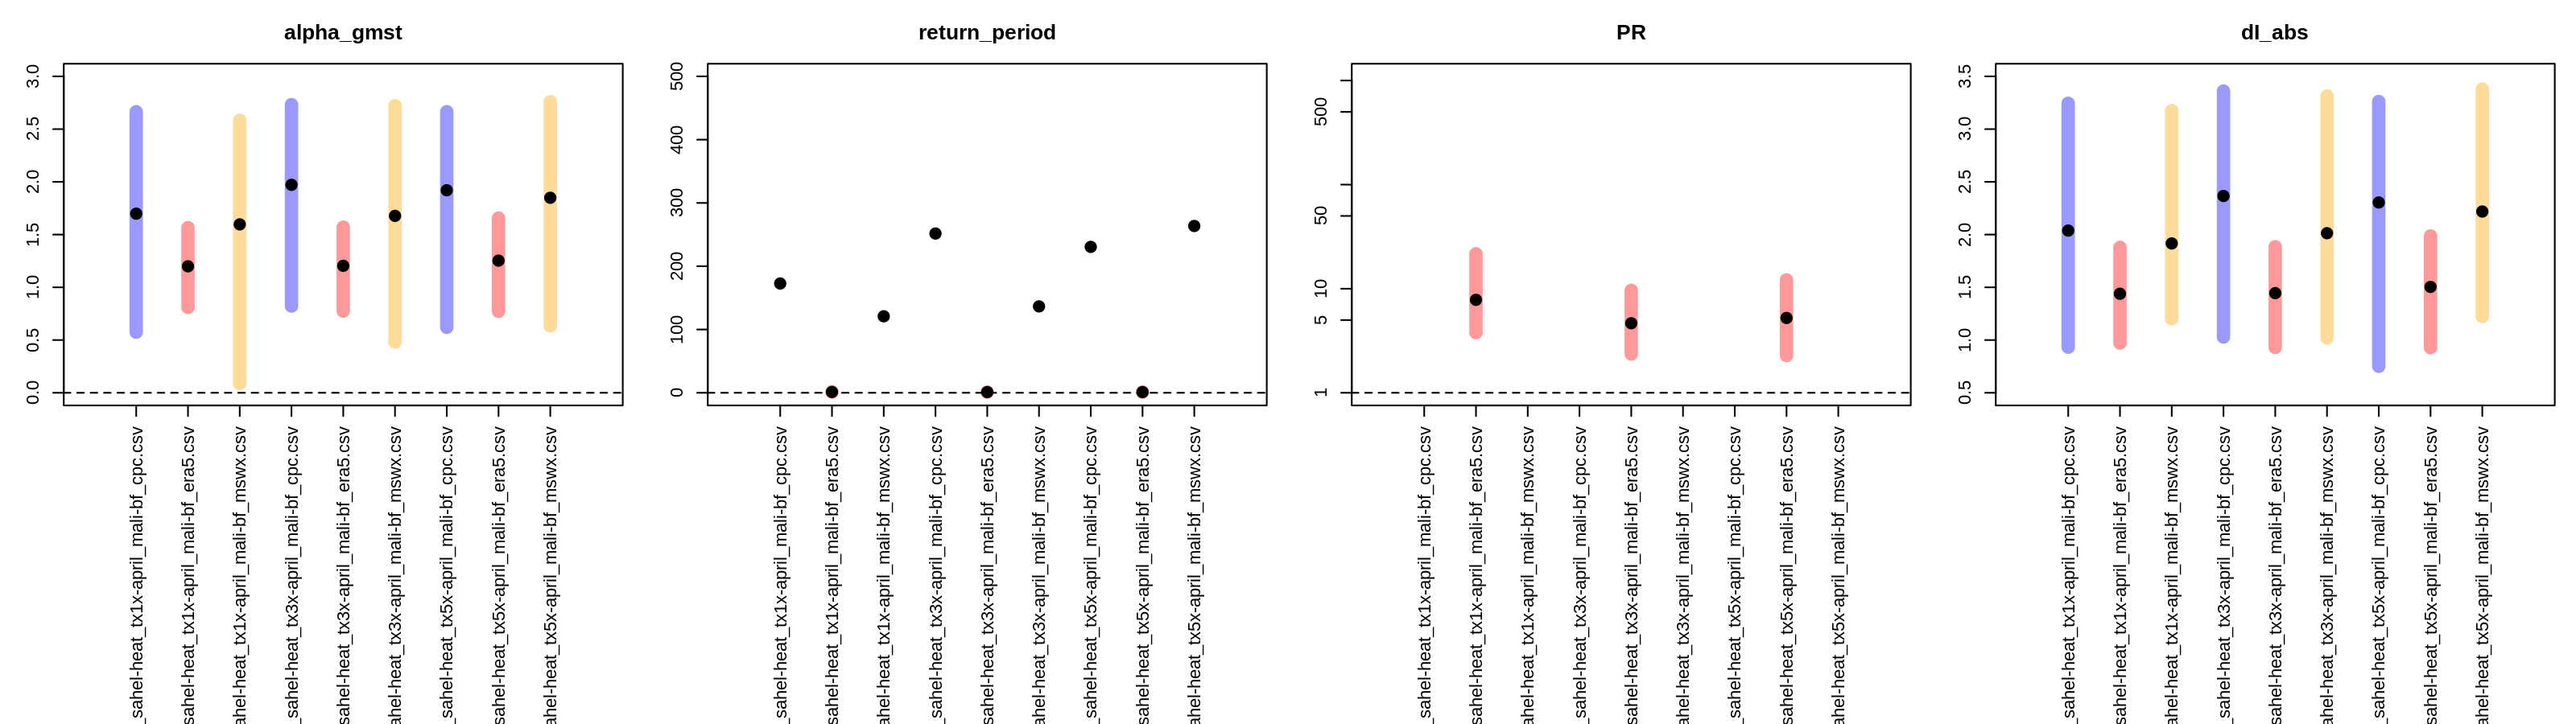

In [38]:
all_res <- res_apr
plot_pars <- c("alpha_gmst", "return_period", "PR", "dI_abs")
prep_window(c(1,4), h = 4.5); par(mar = c(15,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        h = 0
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(all_res[,grepl("dI_abs", colnames(all_res)),]))
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        } else if(grepl("return_period", r)) {
            ylim = c(0,500)
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(rep(c("blue", "red", "orange"), 3), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

## Southern Mali & Burkina Faso - tx5x April

In [2]:
datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

In [3]:
models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tx5x-april_mali-bf_",ds,".dat"), col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
}, simplify = F)

In [4]:
# load results (fitted above)
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res_sahel-heat_tx5x-april_mali-bf_",ds,".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))
obs_res <- obs_res[,rowSums(sapply(c("sigma0", "shape", "event.magnitude_est", "return.period", "PR", "dI.abs"), grepl, colnames(obs_res))) == 1]
write.csv(obs_res, "res_tx5x-april_mali-bf_obs.csv")

In [5]:
tbl_rp <- round(obs_res[,grepl("return.period", colnames(obs_res))], 0)
tbl_di <- round(obs_res[,grepl("dI.abs", colnames(obs_res))], 2)
tbl_pr <- round(obs_res[,grepl("PR", colnames(obs_res))], 1)

setNames(data.frame(rbind("Return period" = paste0(tbl_rp[,1], " (", tbl_rp[,2], ", ", tbl_rp[,3], ")"),
                          "Change in intensity (degC)" = paste0(tbl_di[,1], " (", tbl_di[,2], ", ", tbl_di[,3], ")"),
                          "Probability ratio" = paste0(tbl_pr[,1], " (", tbl_pr[,2], ", ", tbl_pr[,3], ")"))), toupper(datasets))

,CPC,ERA5,MSWX
,<chr>,<chr>,<chr>
Return period,"231 (33, Inf)","37 (12, Inf)","264 (34, Inf)"
Change in intensity (degC),"2.3 (0.75, 3.26)","1.64 (1.19, 2.14)","2.22 (1.22, 3.38)"
Probability ratio,"Inf (6.4, Inf)","Inf (14294.2, Inf)","Inf (38.1, Inf)"


### Plots

In [28]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png("fig/trendplots_tx5x_mali-bf.png", height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.5, cex.axis = 1.5); {
    par(mfrow = c(1,3))
    for(ds in datasets) {
        
        plot_trend(models[[ds]], ylim = c(36,45), main = toupper(ds), ylab = "Temperature (degC)")
        df <- models[[ds]]$data
        lines(df$year, fitted(loess(tas ~ year, df)), col = "red3", lwd = 2)
    }
}; dev.off()

png 
  2

In [8]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png("fig/gmst-trendplots_tx5x_mali-bf.png", height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,3), mar = c(5.1,4.5,4.1,2.1))
    for(ds in datasets) {
        
        plot_covtrend(models[[ds]], xcov = "gmst", ylim = c(36,45), ci_cov = data.frame("gmst" = c("pi" = -1.2, "now" = 0)), nsamp = 1000, main = toupper(ds), ylab = "Temperature (degC)")
        df <- models[[ds]]$data
    }
}; dev.off()

png 
  2

In [58]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png(paste0("fig/returnlevelplots_tx5x_mali-bf.png"), height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,3))
    for(ds in datasets) {
        
        plot_returnlevels(models[[ds]], ylim = c(36,45), cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 10, main = toupper(ds), ylab = "Temperature (degC)", legend_pos = "bottomright")
    }
}; dev.off()

png 
  2

### Bayesian parameter estimates

In [4]:
datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tx5x-april_mali-bf_",ds,".dat"), col.names = c("year", "tas")))
    mdl_mle <- fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
    mdl <- fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian")
    save(mdl, file = paste0("fitted/tx5x-april_mali-bf_",ds,".rdata"))
}, simplify = F)

Warning message in fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian"):
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in fevd(x = x, data = data, threshold = u, threshold.fun = u.fun, :
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian"):
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in fevd(x = x, data = data, threshold = u, threshold.fun = u.fun, :
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in log

In [5]:
ds <- "mswx"
df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tx5x-april_mali-bf_",ds,".dat"), col.names = c("year", "tas")))
mdl_ml <- fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)

In [6]:
set.seed(42)
mdl <- fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian", type = "GEV", initial = as.list(setNames(mdl_ml$par, c("mu0", "scale", "mu1", "shape"))))

Warning message in fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian", :
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in fevd(x = x, data = data, threshold = u, threshold.fun = u.fun, :
“fevd: L-moments and Moment initial parameter estimates could not be calculated.  Using arbitrary starting values.”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”


In [188]:
qrp <- function(mdl) 1/pextRemes(mdl, mdl$x[mdl$cov.data$year == 2024], qcov = make.qcov(mdl, vals = list("mu1" = 0)), lower = F)

In [189]:
rbind("ML" = sapply(models, function(mdl) return_period(fit_ns("gev", "shift", mdl$cov.data, "tas", c("gmst"), lower = F))[length(mdl$x)]),
      "Bayesian" = sapply(models, qrp))

,cpc,era5,mswx
ML,230.5548,36.87977,263.5735
Bayesian,60.6610,Inf,Inf


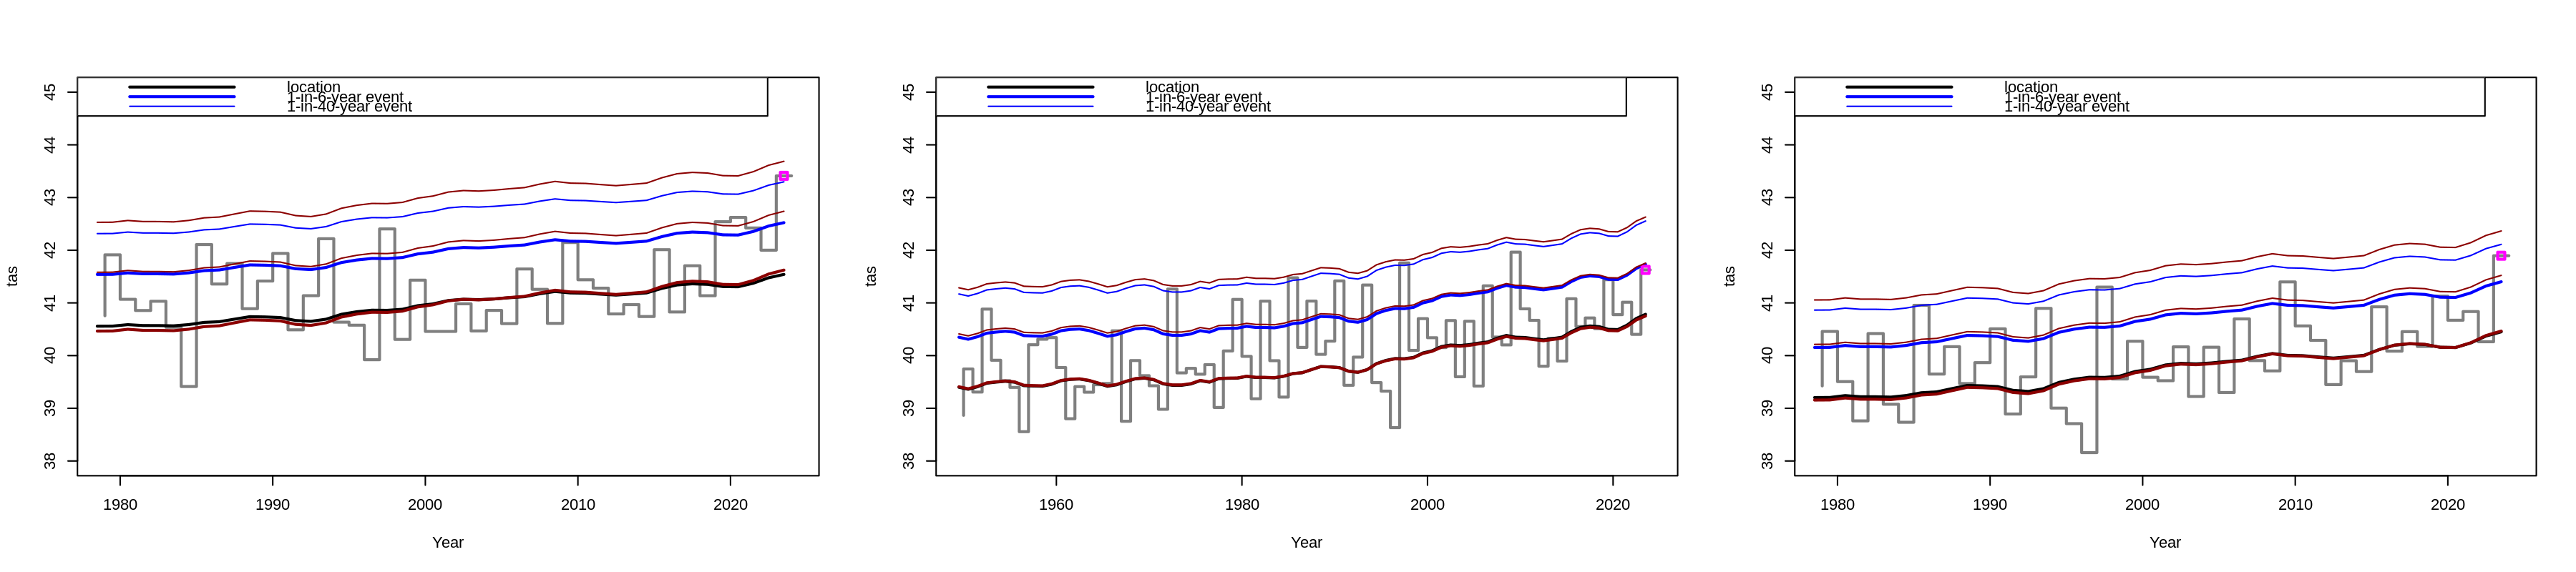

In [175]:
prep_window(c(1,3), w = 6)

for (ds in datasets) {
    mdl <- models[[ds]]
    
    ml_mdl <- fit_ns("gev", "shift", mdl$cov.data, "tas", c("gmst"), lower = F) 
    
    plot_trend(ml_mdl, ylim = c(38,45))
    
    lines(mdl$cov.data$year-0.5, findpars(mdl)$location, lwd = 2, col = "red4")
    lines(mdl$cov.data$year-0.5, return.level(mdl, 6), lwd = 1, col = "red4")
    lines(mdl$cov.data$year-0.5, return.level(mdl, 40), lwd = 1, col = "red4")
}

## Southern Mali & Burkina Faso - tn5x April

In [14]:
datasets <- c("era5", "mswx")
nobs <- length(datasets)

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

In [15]:
models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tn5x-april_mali-bf_",ds,".dat"), col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
}, simplify = F)

In [16]:
# load results (fitted above)
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res_sahel-heat_tn5x-april_mali-bf_",ds,".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))
obs_res <- obs_res[,rowSums(sapply(c("sigma0", "shape", "event.magnitude_est", "return.period", "PR", "dI.abs"), grepl, colnames(obs_res))) == 1]
write.csv(obs_res, "res_tn5x-april_mali-bf_obs.csv")

In [17]:
# plots of fitted trend
prep_window(c(1,nobs), w = 6)
png("fig/trendplots_tn5x_mali-bf.png", height = 480/1.5, width = 480*nobs); par(cex.main = 2, lwd = 2, cex.lab = 1.5, cex.axis = 1.5); {
    par(mfrow = c(1,nobs))
    for(ds in datasets) {
        plot_trend(models[[ds]], ylim = c(24,32), main = toupper(ds), ylab = "Temperature (degC)")

        df <- models[[ds]]$data
        lines(df$year, fitted(loess(tas ~ year, df)), col = "red3", lwd = 2)
    }
}; dev.off()

png 
  2

In [18]:
tbl_rp <- round(obs_res[,grepl("return.period", colnames(obs_res))], 0)
tbl_di <- round(obs_res[,grepl("dI.abs", colnames(obs_res))], 2)
tbl_pr <- round(obs_res[,grepl("PR", colnames(obs_res))], 1)

setNames(data.frame(rbind("Return period" = paste0(tbl_rp[,1], " (", tbl_rp[,2], ", ", tbl_rp[,3], ")"),
                          "Change in intensity (degC)" = paste0(tbl_di[,1], " (", tbl_di[,2], ", ", tbl_di[,3], ")"),
                          "Probability ratio" = paste0(tbl_pr[,1], " (", tbl_pr[,2], ", ", tbl_pr[,3], ")"))), toupper(datasets))

,ERA5,MSWX
,<chr>,<chr>
Return period,"11 (5, 37)","21 (7, Inf)"
Change in intensity (degC),"2.03 (1.44, 2.69)","1.83 (0.89, 2.77)"
Probability ratio,"Inf (466.1, Inf)","Inf (6.2, Inf)"


### Plots

In [19]:
# plots of fitted trend
prep_window(c(1,nobs), w = 6)
png(paste0("fig/gmst-trendplots_tn5x_mali-bf.png"), height = 480/1.5, width = 480*nobs); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,nobs))
    for(ds in datasets) {
        
        plot_covtrend(models[[ds]], xcov = "gmst", ylim = c(24,32), ci_cov = data.frame("gmst" = c("pi" = -1.2, "now" = 0)), nsamp = 1000, main = toupper(ds), ylab = "Temperature (degC)")
        df <- models[[ds]]$data
    }
}; dev.off()

png 
  2

In [85]:
# plots of fitted trend
prep_window(c(1,nobs), w = 6)
png(paste0("fig/returnlevelplots_tn5x_mali-bf.png"), height = 480/1.5, width = 480*nobs); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,nobs))
    for(ds in datasets) {
        
        plot_returnlevels(models[[ds]], ylim = c(24,32), cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 1000, main = toupper(ds), ylab = "Temperature (degC)")
    }
}; dev.off()

png 
  2

## Sahel grid box - tx5x April

In [9]:
datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

In [10]:
models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tx5x-april_",box_str,"_",ds,".dat"), col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
}, simplify = F)

In [11]:
# load results (fitted above)
obs_res <- data.frame(t(sapply(datasets, function(ds) {
    res <- read.csv(paste0("res/res_sahel-heat_tx5x-april_",box_str,"_",ds,".csv"), row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
})))
obs_res <- obs_res[,rowSums(sapply(c("sigma0", "shape", "event.magnitude_est", "return.period", "PR", "dI.abs"), grepl, colnames(obs_res))) == 1]
write.csv(obs_res, paste0("res_tx5x-april_",box_str,"_obs.csv"))

In [12]:
tbl_rp <- round(obs_res[,grepl("return.period", colnames(obs_res))], 0)
tbl_di <- round(obs_res[,grepl("dI.abs", colnames(obs_res))], 2)
tbl_pr <- round(obs_res[,grepl("PR", colnames(obs_res))], 1)

setNames(data.frame(rbind("Return period" = paste0(tbl_rp[,1], " (", tbl_rp[,2], ", ", tbl_rp[,3], ")"),
                          "Change in intensity (degC)" = paste0(tbl_di[,1], " (", tbl_di[,2], ", ", tbl_di[,3], ")"),
                          "Probability ratio" = paste0(tbl_pr[,1], " (", tbl_pr[,2], ", ", tbl_pr[,3], ")"))), toupper(datasets))

,CPC,ERA5,MSWX
,<chr>,<chr>,<chr>
Return period,"43 (14, Inf)","7 (4, 16)","27 (9, Inf)"
Change in intensity (degC),"1.71 (0.61, 2.74)","1.46 (1.03, 1.86)","1.81 (1.01, 2.64)"
Probability ratio,"3331.9 (2, Inf)","154.1 (12.9, Inf)","Inf (6, Inf)"


### Plots

In [90]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png(paste0("fig/trendplots_tx5x_",box_str,".png"), height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.5, cex.axis = 1.5); {
    par(mfrow = c(1,3))
    for(ds in datasets) {
        plot_trend(models[[ds]], ylim = c(36,45), main = toupper(ds), ylab = "Temperature (degC)")

        df <- models[[ds]]$data
        lines(df$year, fitted(loess(tas ~ year, df)), col = "red3", lwd = 2)
    }
}; dev.off()

png 
  2

In [13]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png(paste0("fig/gmst-trendplots_tx5x_",box_str,"png"), height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,3))
    for(ds in datasets) {
        
        plot_covtrend(models[[ds]], xcov = "gmst", ylim = c(36,45), ci_cov = data.frame("gmst" = c("pi" = -1.2, "now" = 0)), nsamp = 1000, main = toupper(ds), ylab = "Temperature (degC)")
        df <- models[[ds]]$data
    }
}; dev.off()

png 
  2

In [92]:
# plots of fitted trend
prep_window(c(1,3), w = 6)
png(paste0("fig/returnlevelplots_tx5x_",box_str,".png"), height = 480/1.5, width = 480*3); par(cex.main = 2, lwd = 2, cex.lab = 1.25, cex.axis = 1.5); {
    par(mfrow = c(1,3))
    for(ds in datasets) {
        
        plot_returnlevels(models[[ds]], ylim = c(37, 45), cov_f = data.frame(gmst = 0), cov_cf = data.frame(gmst = -1.2), nsamp = 1000, main = toupper(ds), ylab = "Temperature (degC)")
    }
}; dev.off()

png 
  2

### Bayesian parameter estimates

In [6]:
models <- sapply(datasets, function(ds) {
    df <- merge(gmst, load_ts(paste0("ts/sahel-heat_tx5x-april_",box_str,"_",ds,".dat"), col.names = c("year", "tas")))
    mdl <- fevd(df$tas, data = df, location.fun = ~gmst, method = "Bayesian")
    save(mdl, file = paste0("fitted/tx5x-april_",box_str,"_",ds,".rdata"))
    mdl
}, simplify = F)

In [7]:
qrp <- function(mdl) 1/pextRemes(mdl, mdl$x[mdl$cov.data$year == 2024], qcov = make.qcov(mdl, vals = list("mu1" = 0)), lower = F)

In [8]:
rbind("ML" = sapply(models, function(mdl) return_period(fit_ns("gev", "shift", mdl$cov.data, "tas", c("gmst"), lower = F))[length(mdl$x)]),
      "Bayesian" = sapply(models, qrp))


,cpc,era5,mswx
ML,43.12782,7.431982,27.12266
Bayesian,23.71093,6.675973,14.07430


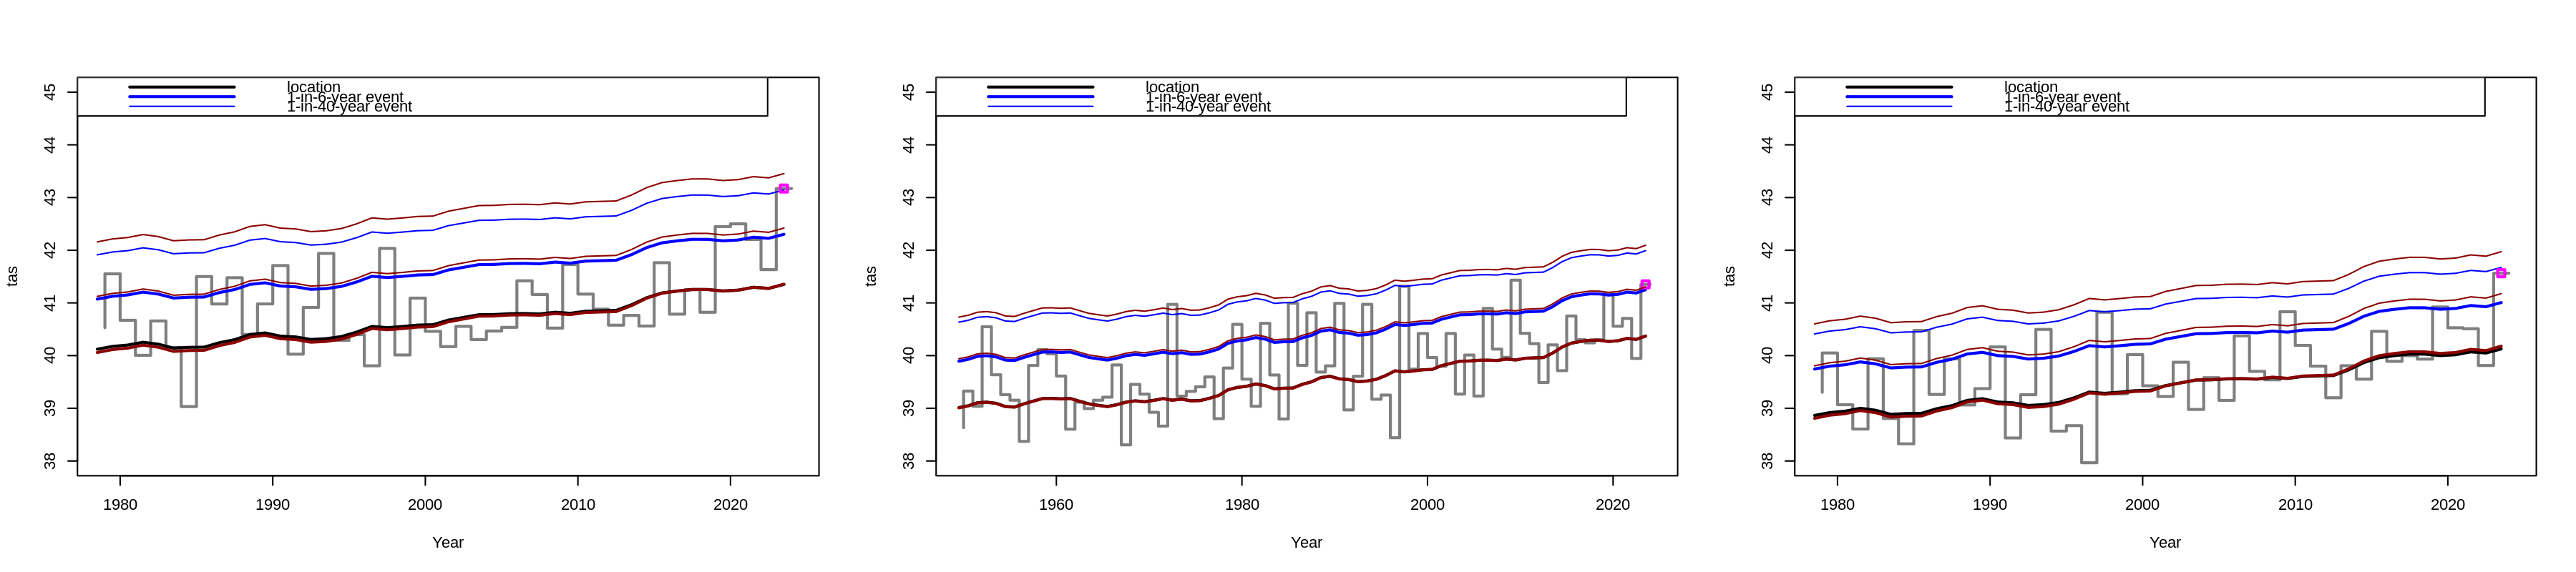

In [9]:
prep_window(c(1,3), w = 6)

for (ds in datasets) {
    mdl <- models[[ds]]
    
    ml_mdl <- fit_ns("gev", "shift", mdl$cov.data, "tas", c("gmst"), lower = F) 
    
    plot_trend(ml_mdl, ylim = c(38,45))
    
    lines(mdl$cov.data$year-0.5, findpars(mdl)$location, lwd = 2, col = "red4")
    lines(mdl$cov.data$year-0.5, return.level(mdl, 6), lwd = 1, col = "red4")
    lines(mdl$cov.data$year-0.5, return.level(mdl, 40), lwd = 1, col = "red4")

}

## Per grid cell

In [50]:
varnm <- "tmin"

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

cov_2024 <- data.frame(gmst = 0)
cov_cf <- rbind("pi" = data.frame(gmst = -1.2), "80s" = data.frame(gmst = -0.8), "00s" = -0.5)

In [51]:
fl = list.files("data", pattern = paste0(varnm,"_mswx_flattened"), full.names = T)

for(fnm in fl) {
    
    res_fnm <- gsub("data", "fitted", fnm)
    
    if (!file.exists(res_fnm)) {
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all grid cells
        models <- sapply(colnames(df)[-(1:2)], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                fit_ns("gev", "shift", df_c, cnm, c("gmst"), lower = F)
            }, error = function(cond) { return(NULL) })
        }, simplify = F)

        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 16)
            }})
        write.csv(fitted_res, res_fnm)
    }
}

# Contribution from Nino3.4?

## Nino3.4 DJF


In [59]:
varnm <- "tx5x"
region <- box_str

datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

nino <- read.csv("ts/nino_djf.csv", col.names = c("year", "nino"))

cov_2024 <- data.frame(gmst = 0, nino = nino$nino[nino$year == 2024])
cov_neut <- data.frame(gmst = 0, nino = 0)

In [60]:
models_gmst <- sapply(datasets, function(ds) {
    df <- merge(merge(gmst, nino), load_ts(paste0("ts/sahel-heat_",varnm,"-april_",region,"_",ds,".dat"), col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst"), lower = F)    
}, simplify = F)

models_nino <- sapply(datasets, function(ds) {
    df <- merge(merge(gmst, nino), load_ts(paste0("ts/sahel-heat_",varnm,"-april_",region,"_",ds,".dat"), col.names = c("year", "tas")))
    fit_ns("gev", "shift", df, "tas", c("gmst", "nino"), lower = F)    
}, simplify = F)

In [61]:
# pretty marginal difference in AIC
rbind("gmst" = sapply(models_gmst, "aic"), "gmst+nino" = sapply(models_nino, "aic"))

,cpc,era5,mswx
gmst,104.2407,153.6945,98.93280
gmst+nino,102.8153,147.6836,97.36679


In [62]:
# very small increase due to El Nino
sapply(models_nino, mdl_ests, cov_f = cov_2024, cov_cf = cov_neut)

,cpc,era5,mswx
mu0,41.51522305,40.68290974,40.34272278
sigma0,0.62464830,0.60255332,0.63791369
alpha_gmst,1.50270656,1.27986204,1.48335904
alpha_nino,0.21320332,0.26804867,0.21432175
shape,-0.19308970,-0.26908486,-0.31326543
disp,0.01501097,0.01476644,0.01577401
event_magnitude,43.17075348,41.46742249,41.65851974
return_period,30.54220749,4.19929440,18.84229956
PR,1.35802251,1.30595527,1.48938675
dI_abs,0.09757735,0.12267857,0.09808922


In [63]:
# but let's bootstrap it, just to make sure
boot_res <- sapply(models_nino, function(mdl) boot_ci(mdl, cov_f = cov_2024, cov_cf = cov_neut), simplify = F)

In [64]:
# so there is evidence for an additional increase due to the DJF El Nino conditions, but it's very weak
di <- round(abind::abind(boot_res, along = 0)[,"dI_abs",],2)
pr <- round(abind::abind(boot_res, along = 0)[,"PR",],2)

In [65]:
data.frame(paste0(di[,1], " (", di[,2], ", ", di[,3], ")"))

paste0.di...1.........di...2.........di...3.......
<chr>
"0.1 (-0.01, 0.21)"
"0.12 (0.03, 0.22)"
"0.1 (-0.05, 0.21)"


In [66]:
data.frame(paste0(pr[,1], " (", pr[,2], ", ", pr[,3], ")"))

paste0.pr...1.........pr...2.........pr...3.......
<chr>
"1.36 (0.98, 39.07)"
"1.31 (1.07, 1.67)"
"1.49 (0.93, Inf)"


## January Nino3.4


In [20]:
datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# Peak Nino (January values only)
nino <- read.csv("../10_misc/detrended_nino34/nino34_detrended.csv")
nino <- nino[substr(nino$time,6,7) == "01",]
nino$year <- as.integer(substr(nino$time,1,4))

tas <- load_ts(paste0("ts/sahel-heat_tx5x-april_mali-bf_mswx.dat"), col.names = c("year", "tas"))

df <- merge(merge(nino, gmst), tas)

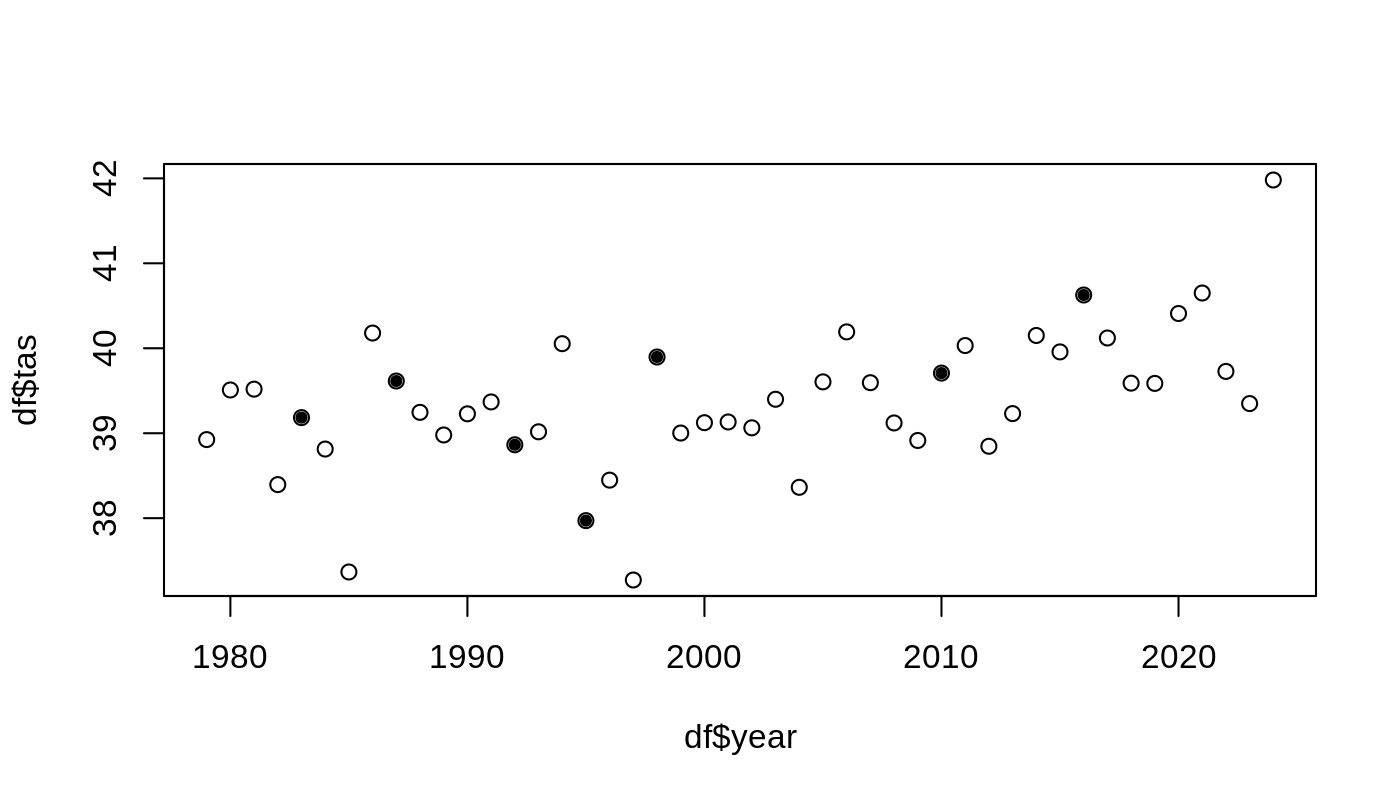

In [21]:
prep_window(w = 7)

# no evidence that peak temperatures are higher in El Nino years.
plot(df$year, df$tas, pch = 1)
points(df[df$nino > 0.5, c("year","tas")], pch = 20)

## Declining Nino3.4


In [14]:
datasets <- c("cpc", "era5", "mswx")

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

# Peak Nino (January values only)
nino <- read.csv("../10_misc/detrended_nino34/nino34_detrended.csv")
nino <- data.frame(year = as.integer(substr(nino$time[substr(nino$time,6,7) == "03"],1,4)), nino = nino$nino[substr(nino$time,6,7) == "03"] - nino$nino[substr(nino$time,6,7) == "01"])

tas <- load_ts(paste0("ts/sahel-heat_tx5x-april_mali-bf_mswx.dat"), col.names = c("year", "tas"))


df <- merge(merge(nino, gmst), tas)

# - possibly the effect would be clearer in shorter heatwaves? But we see no signal in these 5-day events
# - also possible that there are more heatwaves after the 

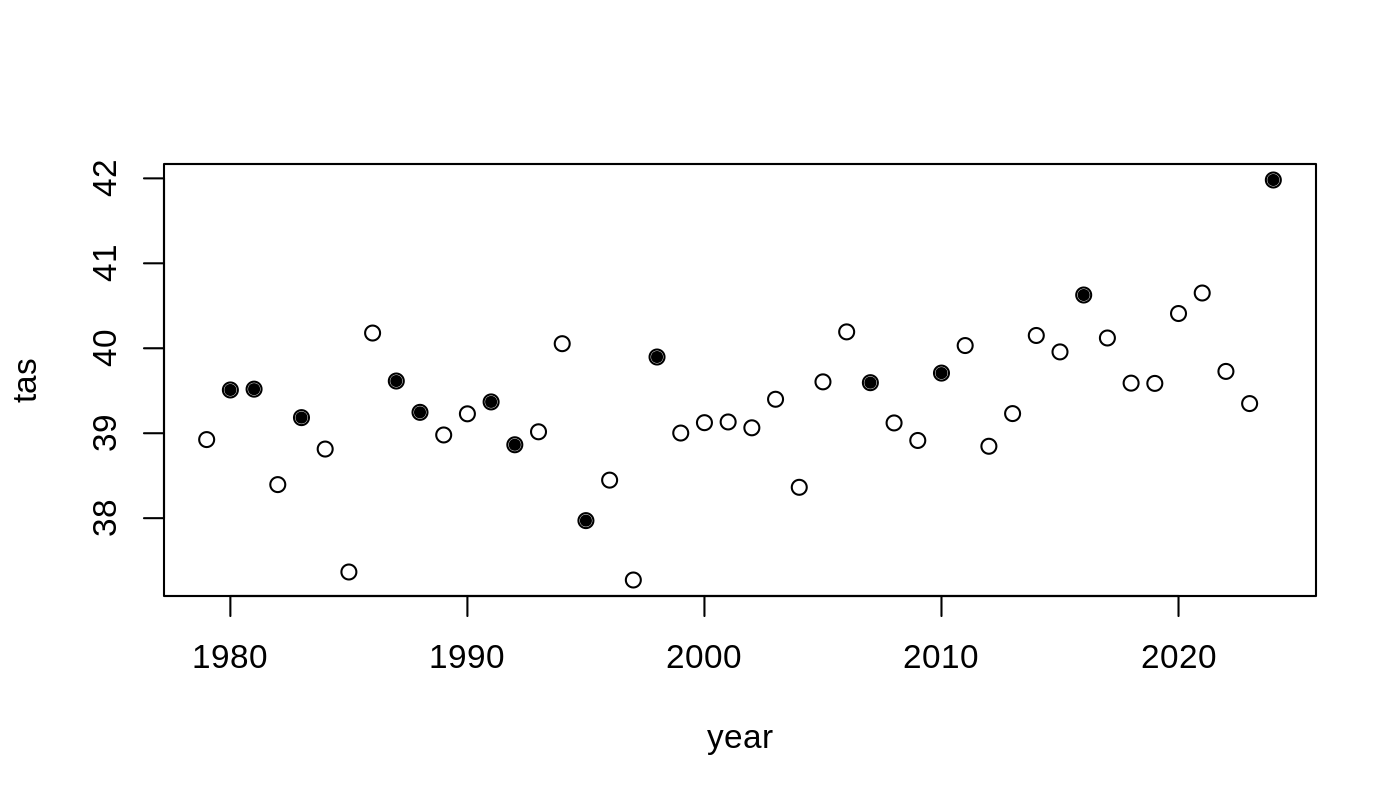

In [15]:
prep_window(w = 7)
# no evidence that peak temperatures are higher in El Nino years.
plot(df[, c("year","tas")], pch = 1)
points(df[df$nino <= 0, c("year","tas")], pch = 20, col = "black")

---
# Climate models

## tx5x - Southern Mali & Burkina Faso

In [193]:
rp <- 100
for (fnm in list.files("ts", pattern = "cmip6_tx5x-april_mali-bf", full.names = T)) {
    
    if(grepl("AWI", fnm)) next
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "tas"))
        gmst_fnm <- list.files("ts", pattern = paste0("SGSAT.+", gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][5:6], collapse = "_"))), full.names = T)
        if(length(gmst_fnm) == 0) next
        
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        df <- merge(ts, gmst)

        cov_2024 <- df[df$year == 2024, "gmst", drop = F]
        cov_hist <- df[df$year == 2024, "gmst", drop = F] - 1.2
        cov_fut <- df[df$year == 2024, "gmst", drop = F] + 0.8

        mdl <- fit_ns("gev", "shift", df, "tas", "gmst", lower = F, method = "Nelder-Mead")

        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2024, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = 500)

        write.csv(res, res_fnm)
    }
}

In [203]:
# compile results
res <- t(sapply(list.files("res", pattern = "cmip6_tx5x-april_mali-bf", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][6:7], collapse = "_")))
write.csv(res, "res_tx5x-april_mali-bf_cmip6.csv")

### Check effect of using 200-year return period

In [2]:
# test effect of using 200-year return period instead of 100-year
rp <- 200
for (fnm in list.files("ts", pattern = "cmip6_tx5x-april_mali-bf", full.names = T)) {
    
    if(grepl("AWI", fnm)) next
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res200_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "tas"))
        gmst_fnm <- list.files("ts", pattern = paste0("SGSAT.+", gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][5:6], collapse = "_"))), full.names = T)
        if(length(gmst_fnm) == 0) next
        
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        df <- merge(ts, gmst)

        cov_2024 <- df[df$year == 2024, "gmst", drop = F]
        cov_hist <- df[df$year == 2024, "gmst", drop = F] - 1.2
        cov_fut <- df[df$year == 2024, "gmst", drop = F] + 0.8

        mdl <- fit_ns("gev", "shift", df, "tas", "gmst", lower = F, method = "Nelder-Mead")

        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2024, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = 50)

        write.csv(res, res_fnm)
    }
}

In [4]:
# compile results
res <- t(sapply(list.files("res", pattern = "200.+cmip6_tx5x-april_mali-bf", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][6:7], collapse = "_")))
write.csv(res, "res200_tx5x-april_mali-bf_cmip6.csv")

## tx5x - Sahel region

In [41]:
rp <- 30
for (fnm in list.files("ts", pattern = paste0("cmip6_tx5x-april_",box_str), full.names = T)) {
    print(fnm)
    if(grepl("EC-Earth3-Veg_r1i1p1f1", fnm) ) next  #| grepl("INM-CM4-8", fnm) | grepl("MRI-ESM2-0", fnm )
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "tas"))
        gmst_fnm <- list.files("ts", pattern = paste0("SGSAT.+", gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][8:9], collapse = "_"))), full.names = T)
        if(length(gmst_fnm) == 0) next
        
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        df <- merge(ts, gmst)

        cov_2024 <- df[df$year == 2024, "gmst", drop = F]
        cov_hist <- df[df$year == 2024, "gmst", drop = F] - 1.2
        cov_fut <- df[df$year == 2024, "gmst", drop = F] + 0.8

        mdl <- fit_ns("gev", "shift", df, "tas", "gmst", lower = F, method = "Nelder-Mead") # BFGS fails for some reason        
        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2024, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = 500)

        write.csv(res, res_fnm)
    }
}

[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_ACCESS-CM2_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_ACCESS-ESM1-5_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_AWI-CM-1-1-MR_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_CanESM5_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_E3SM-1-0_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_EC-Earth3_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_EC-Earth3-Veg_r1i1p1f1.dat"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_EC-Earth3-Veg-LR_r1i1p1f1.dat"
[1] "!"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_INM-CM4-8_r1i1p1f1.dat"
[1] "!"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_INM-CM5-0_r1i1p1f1.dat"
[1] "!"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_MIROC6_r1i1p1f1.dat"
[1] "!"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_MPI-ESM1-2-HR_r1i1p1f1.dat"
[1] "!"
[1] "ts/sahel-heat_cmip6_tx5x-april_-16_20_10_17_MPI-ESM1-2-LR_r1i

In [42]:
# compile results
res <- t(sapply(list.files("res", pattern = paste0("cmip6_tx5x-april_",box_str), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][9:10], collapse = "_")))
write.csv(res, paste0("res_tx5x-april_",box_str,"_cmip6.csv"))

## tx5x - Southern Mali & Burkina Faso

In [276]:
rp <- 20
for (fnm in list.files("ts", pattern = "cmip6_tn5x-april_mali-bf", full.names = T)) {
    
    # if(grepl("AWI", fnm)) next
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "tas"))
        gmst_fnm <- list.files("ts", pattern = paste0("SGSAT.+", gsub(".dat", "", paste0(strsplit(fnm, "_")[[1]][5:6], collapse = "_"))), full.names = T)
        if(length(gmst_fnm) == 0) next
        
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        df <- merge(ts, gmst)

        cov_2024 <- df[df$year == 2024, "gmst", drop = F]
        cov_hist <- df[df$year == 2024, "gmst", drop = F] - 1.2
        cov_fut <- df[df$year == 2024, "gmst", drop = F] + 0.8

        mdl <- fit_ns("gev", "shift", df, "tas", "gmst", lower = F)

        res <- cmodel_results(mdl, rp = rp, cov_f = cov_2024, cov_hist = cov_hist, cov_fut = cov_fut,
                             y_now = 2024, y_start = 1979, y_fut = 2050, nsamp = 500)

        write.csv(res, res_fnm)
    }
}

In [277]:
# compile results
res <- t(sapply(list.files("res", pattern = "cmip6_tn5x-april_mali-bf", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) gsub(".csv", "", paste0(strsplit(rnm, "_")[[1]][6:7], collapse = "_")))
write.csv(res, "res_tn5x-april_mali-bf_cmip6.csv")

# Synthesis

In [9]:
varnm <- "tx5x-april"
region <- "mali-bf"

obs <- read.csv(paste0("res_",varnm, "_", region, "_obs.csv"), row.names = "X")
obs <- obs[c("era5", "mswx"),]
models <- read.csv(paste0("res_",varnm, "_", region, "_cmip6.csv"), row.names = "X")
rownames(models) <- sapply(strsplit(rownames(models), "_"), "[", 1)

# filter out any models identified as not performing as well
exclude_models <- list("tx5x-april_mali-bf" = c("MIROC6"),
                       "tx5x-april_-16_20_10_17" = c("MIROC6"),
                       "tn5x-april_mali-bf" = c())[[paste0(varnm,"_",region)]]
models <- models[!sapply(rownames(models), "%in%", exclude_models),]

In [10]:
synth_dI_attr <- synthesis(obs[,grepl("dI.abs", colnames(obs))], models[,grepl("attr_dI.abs", colnames(models))])$df
synth_dI_proj <- synthesis(obs = NA, models[,grepl("proj_dI.abs", colnames(models))])$df

write.csv(synth_dI_attr, paste0("synth/synth_",varnm,"_",region,"_dI-attr.csv"), row.names = F)
write.csv(synth_dI_proj, paste0("synth/synth_",varnm,"_",region,"_dI-proj.csv"), row.names = F)

In [11]:
# fix infinite upper bounds in model PRs, mark models
models_in <- models[,grepl("proj_PR", colnames(models))]
rownames(models_in) <- sapply(rownames(models_in), function(rnm) if(is.finite(models_in[rnm, "proj_PR_upper"])) {rnm} else{ paste0(rnm,"*")})

zz <- log(models_in)
ub_finite <- zz$proj_PR_est + (zz$proj_PR_est - zz$proj_PR_lower) * 3
zz[!is.finite(zz$proj_PR_upper), "proj_PR_upper"] <- ub_finite[!is.finite(zz$proj_PR_upper)]
models_in <- exp(zz)

synth_PR_proj <- synthesis(NA, models_in, synth_type = "PR")$df
write.csv(synth_PR_proj, paste0("synth/synth_",varnm,"_",region,"_PR-proj.csv"), row.names = F)